In [1]:
import sys
import os
os.chdir("..")
os.chdir("..")
os.chdir("./src")
# sys.path.append("./src")

In [2]:
from IPython import display
from IPython.display import clear_output
import pylab as pl
import numpy as np
import matplotlib.pyplot as plt
from numba import njit, jit
from time import time
# from helpers import *
from LDMIBSS import *
# np.random.seed(100)
%load_ext autoreload
%autoreload 2

In [3]:
N = 10000
NumberofSources = 5
NumberofMixtures = 8
S = generate_correlated_copula_sources(rho = 0.9, df = 4, n_sources = NumberofSources, 
                                       size_sources = N , decreasing_correlation = False)
print("The following is the correlation matrix of sources")
display_matrix(np.corrcoef(S))

# Generate Mxr random mixing from i.i.d N(0,1)
A = np.random.randn(NumberofMixtures,NumberofSources)
X = np.dot(A,S)

SNR = 30
X, NoisePart = addWGN(X, SNR, return_noise = True)

SNRinp = 10 * np.log10(np.sum(np.mean((X - NoisePart)**2, axis = 1)) / np.sum(np.mean(NoisePart**2, axis = 1)))
print("The following is the mixture matrix A")
display_matrix(A)
print("Input SNR is : {}".format(SNRinp))

The following is the correlation matrix of sources


<IPython.core.display.Math object>

The following is the mixture matrix A


<IPython.core.display.Math object>

Input SNR is : 30.007936710772356


In [4]:
s_dim = S.shape[0]
x_dim = X.shape[0]
debug_iteration_point = 200
model = LDMIBSS(s_dim = s_dim, x_dim = x_dim,
                set_ground_truth = True, S = S, A = A)

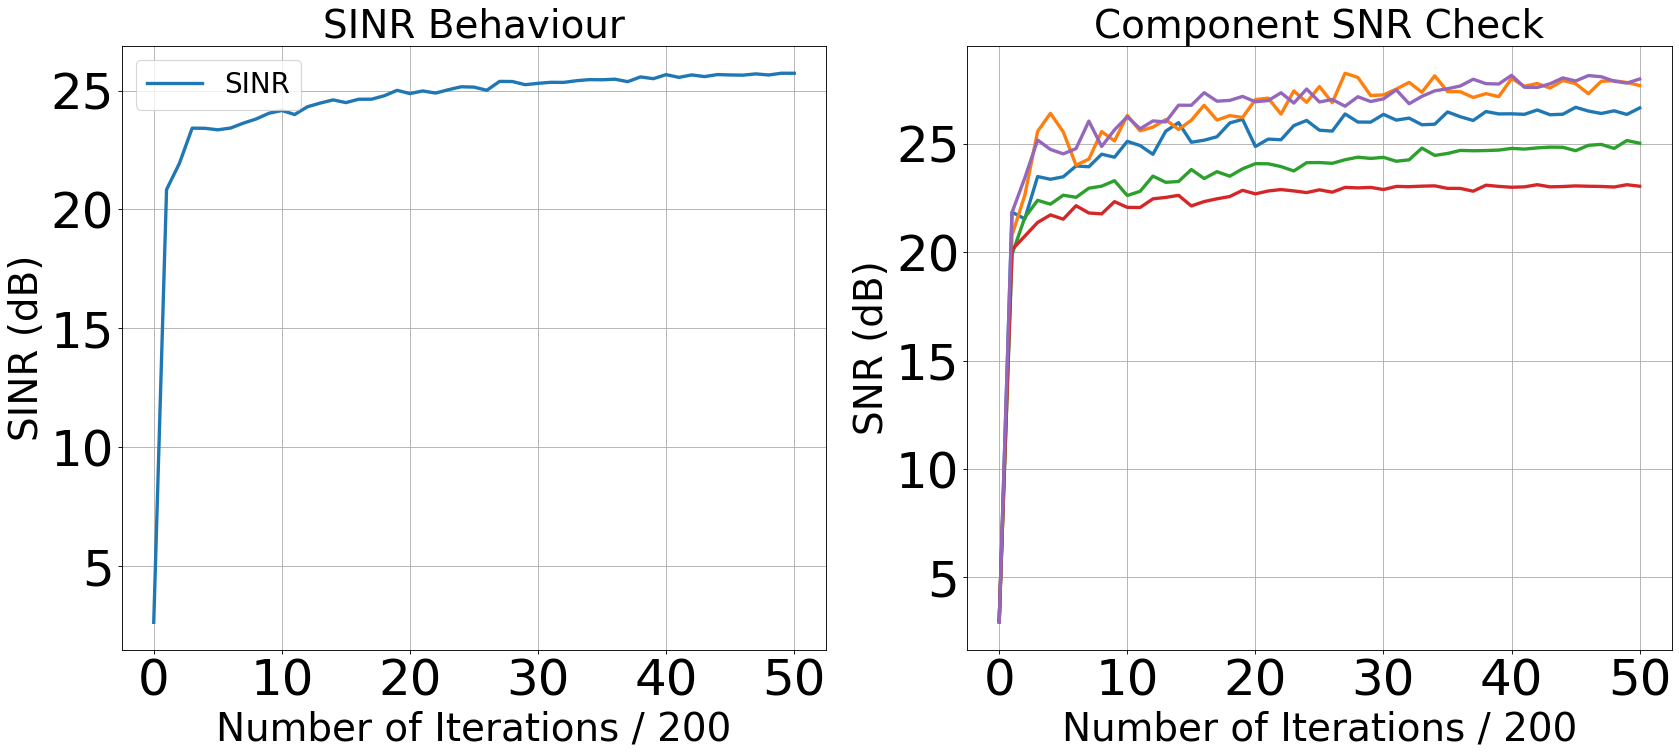

100%|██████████| 10000/10000 [01:10<00:00, 141.75it/s]


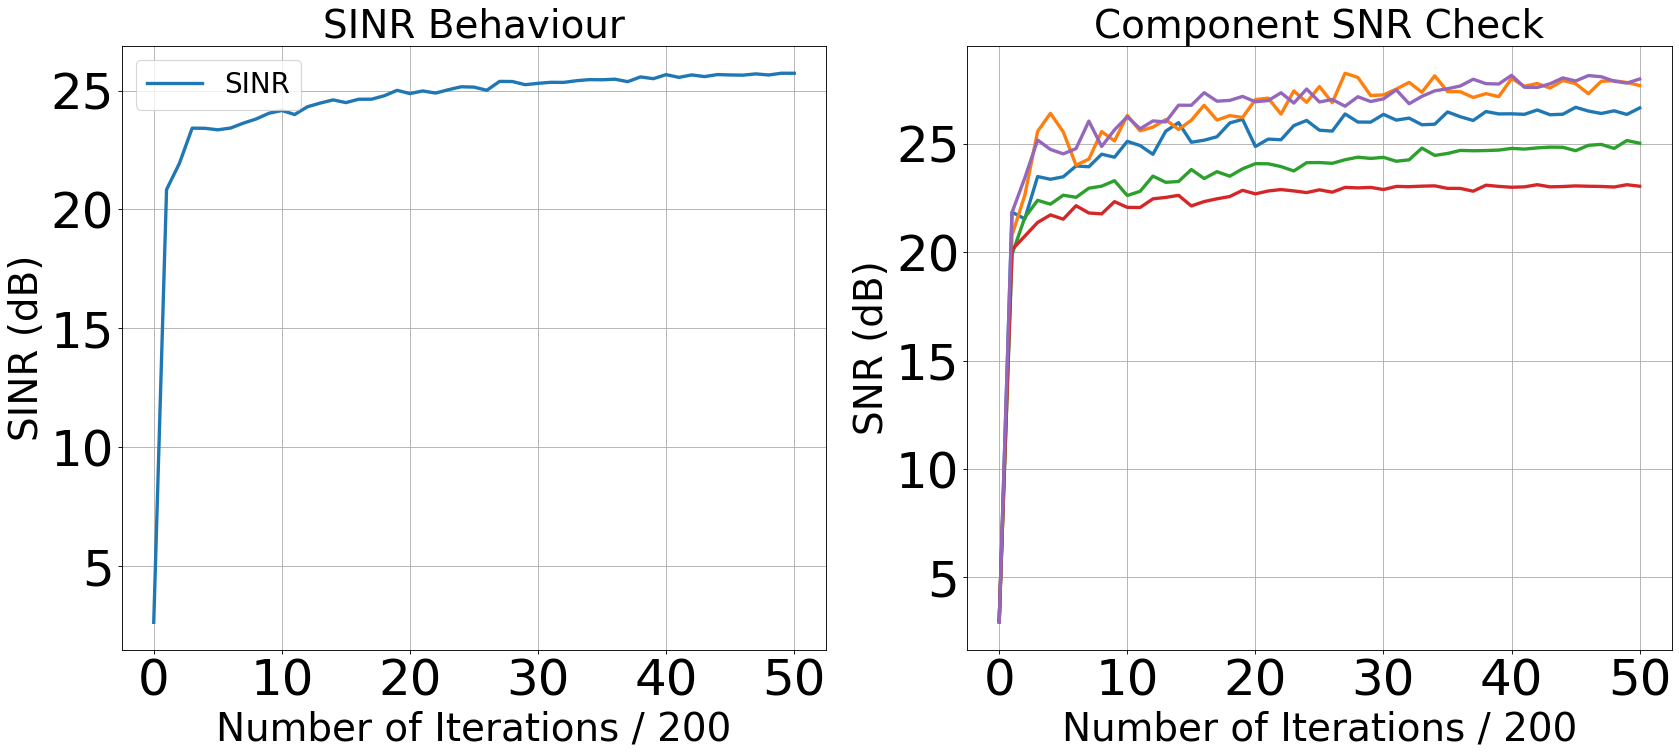

In [5]:
model.fit_batch_nnantisparse(X, epsilon = 1e-5, mu_start = 100, n_iterations = 10000, 
                           method = "covariance", debug_iteration_point = debug_iteration_point,
                           plot_in_jupyter = True)

Final SINR: 25.725437481113865


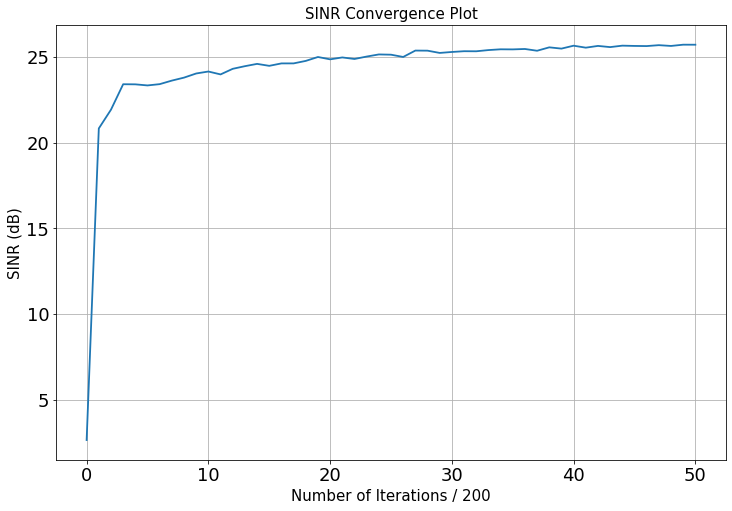

In [6]:
mpl.rcParams['xtick.labelsize'] = 18
mpl.rcParams['ytick.labelsize'] = 18
plot_convergence_plot(model.SINR_list, xlabel = 'Number of Iterations / {}'.format(debug_iteration_point),
                     ylabel = 'SINR (dB)', title = 'SINR Convergence Plot', colorcode = None, linewidth = 1.8)

print('Final SINR: {}'.format(np.array(model.SINR_list[-1])))

In [7]:
W = model.W
Y = W @ X
10 * np.log10(CalculateSINR(Y, S)[0])

25.835154171332544

In [8]:
Y = W @ X
print(Y.shape, X.shape, S.shape)
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T)
coef_ = (Y_ * S.T).sum(axis = 0) / (Y_ * Y_).sum(axis = 0)
Y_ = coef_ * Y_
snr(S.T, Y_)

(5, 10000) (8, 10000) (5, 10000)


array([26.82187329, 28.32534679, 25.02920608, 23.00349238, 28.03386232])

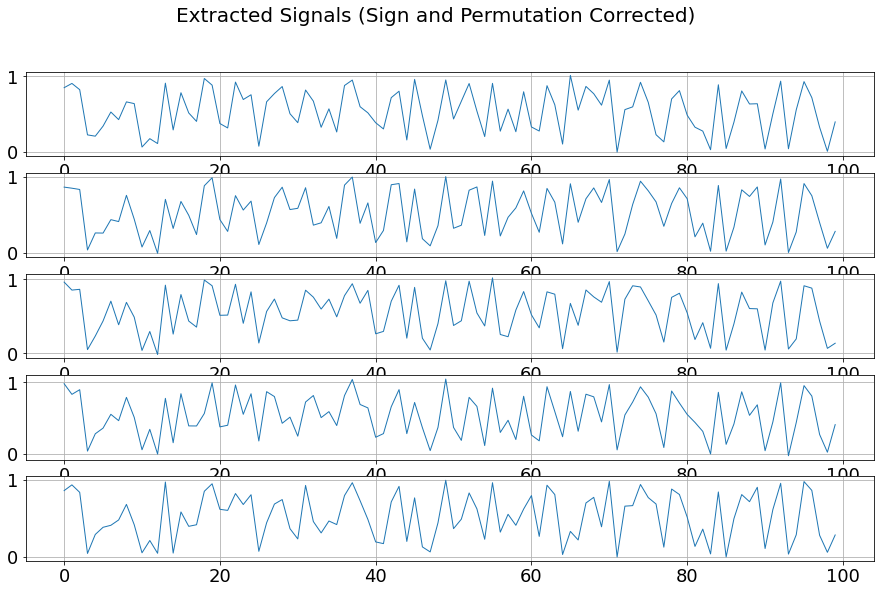

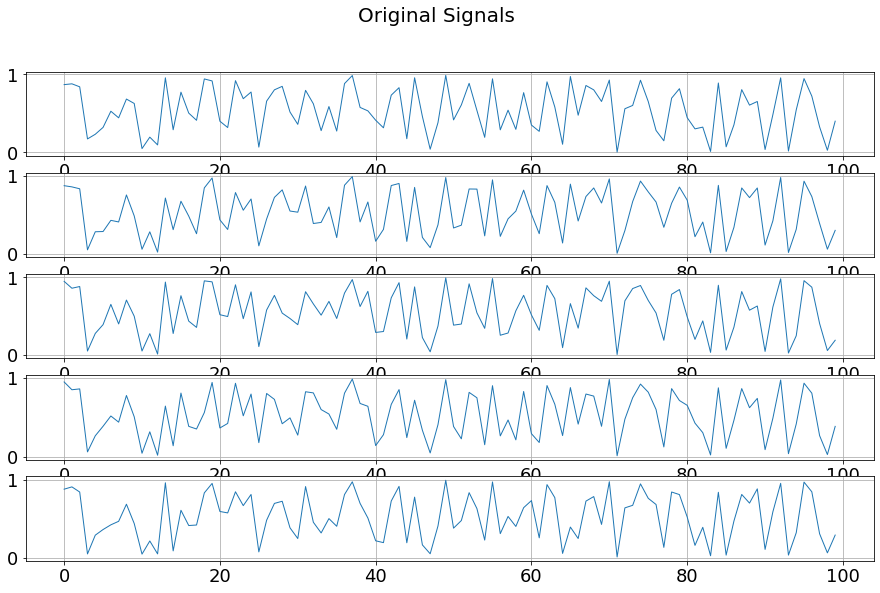

In [9]:
Y = W @ X
Y_ = signed_and_permutation_corrected_sources(S.T,Y.T).T
subplot_1D_signals(X = Y_.T[0:100], title = 'Extracted Signals (Sign and Permutation Corrected)' ,figsize = (15.2,9), colorcode = None)
subplot_1D_signals(X = S.T[0:100], title = 'Original Signals' ,figsize = (15.2,9), colorcode = None)